In [2]:
import pandas as pd
import os 
from src.files import XMLFile, FASTAFile, GBFFFile
from src import get_genome_id
from src.sampler import Sampler 
from src.dataset import Dataset
from torch.utils.data import DataLoader
from utils import * 
from src.genome import ReferenceGenome
from src.tools import NCBIDatasets, Prodigal
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
import dataframe_image as dfi
from sklearn.model_selection import train_test_split

%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ref_out_df = load_ref_out()
ref_out_df = remove_partial(ref_out_df)

ref_out_fp_df = ref_out_df[ref_out_df.n_valid_hits == 0].copy()
ref_out_tp_df = ref_out_df[(ref_out_df.n_valid_hits > 0)].copy()

load_ref_out:   0%|          | 0/137 [00:00<?, ?it/s]

load_ref_out: 100%|██████████| 137/137 [00:10<00:00, 12.95it/s]


remove_partial: Removing 4364 instances marked as partial by both Prodigal and RefSeq from the DataFrame.


In [3]:
print('Maximum false positive length:', ref_out_fp_df.seq.apply(len).max())
print('Minimum false positive length:', ref_out_fp_df.seq.apply(len).min())

Maximum false positive length: 6469
Minimum false positive length: 29


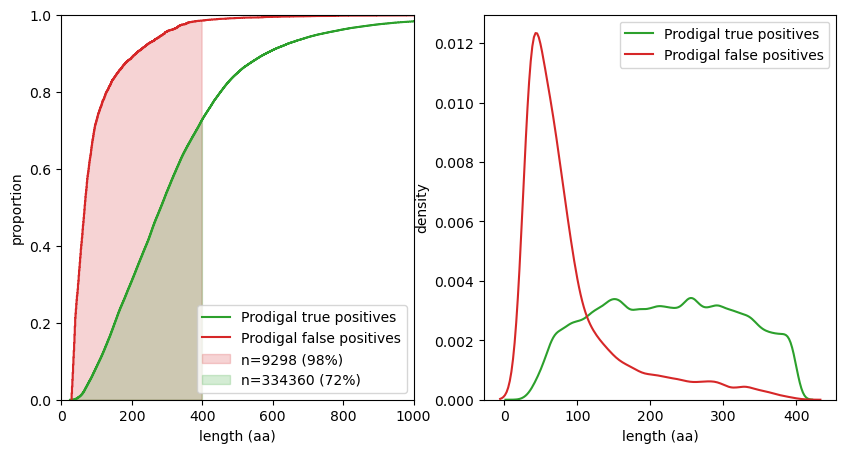

In [4]:
def figure_1(ref_out_df, path:str='../figures/filter-figure_1.png'):

    ref_out_fp_df = ref_out_df[ref_out_df.n_valid_hits == 0].copy()
    ref_out_tp_df = ref_out_df[(ref_out_df.n_valid_hits > 0)].copy()

    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

    ax = axes[0]
    ax = sns.ecdfplot(ref_out_tp_df.seq.apply(len), ax=ax, color='tab:green', label=f'Prodigal true positives')
    ax = sns.ecdfplot(ref_out_fp_df.seq.apply(len), ax=ax, color='tab:red', label=f'Prodigal false positives')

    x_tp, y_tp = ax.get_lines()[0].get_data()
    x_fp, y_fp = ax.get_lines()[1].get_data()

    x_tp, x_fp, y_tp, y_fp = x_tp[1:], x_fp[1:], y_tp[1:], y_fp[1:]

    max_length = 400

    n_tp = (x_tp < max_length).sum()
    n_fp = (x_fp < max_length).sum()
    p_tp = int(n_tp * 100 / len(x_tp))
    p_fp = int(n_fp * 100 / len(x_fp))

    ax.fill_between(x_fp[x_fp < max_length], y_fp[x_fp < max_length], color='tab:red', alpha=0.2, label=f'n={n_fp} ({p_fp}%)')
    ax.fill_between(x_tp[x_tp < max_length], y_tp[x_tp < max_length], color='tab:green', alpha=0.2, label=f'n={n_tp} ({p_tp}%)')
    ax.set_xlim(0, 1000)
    ax.set_ylabel('proportion')
    ax.set_xlabel('length (aa)')
    ax.legend()

    ax = axes[1]
    ref_out_tp_df = ref_out_tp_df[ref_out_tp_df.seq.apply(len) < max_length]
    ref_out_fp_df = ref_out_fp_df[ref_out_fp_df.seq.apply(len) < max_length]
    sns.kdeplot(ref_out_tp_df.seq.apply(len), ax=ax, color='tab:green', label=f'Prodigal true positives')
    sns.kdeplot(ref_out_fp_df.seq.apply(len), ax=ax, color='tab:red', label=f'Prodigal false positives')
    ax.legend()
    ax.set_ylabel('density')
    ax.set_xlabel('length (aa)')

    plt.show()

figure_1(ref_out_df)

In [27]:
# The length distributions differ enough that I am a little worried that the model will take the "easy" way out and just
# learn sequence length. 
dataset_df = pd.concat([ref_out_fp_df.assign(label=1), ref_out_tp_df.assign(label=0)], axis=0)
dataset_df = dataset_df[dataset_df.seq.apply(len) < 400]

train_dataset_df, test_dataset_df = train_test_split(dataset_df, test_size=0.2, train_size=0.8)
train_dataset_df.convert_dtypes().to_csv('../data/filter_dataset_train.csv')
test_dataset_df.convert_dtypes().to_csv('../data/filter_dataset_test.csv')

In [32]:
def fix_dtypes(df:pd.DataFrame):
    df = df.copy().convert_dtypes()
    for col in df.columns:
        if df[col].dtype == 'string[python]':
            df[col] = df[col].fillna('none')
        if df[col].dtype == 'boolean':
            df[col] = df[col].fillna(False)
        if df[col].dtype in ['Int64', 'Float64']:
            df[col].fillna(-1)
    return df 

fix_dtypes(train_dataset_df).to_csv('../data/filter_dataset_train.csv')
fix_dtypes(test_dataset_df).to_csv('../data/filter_dataset_test.csv')

In [8]:
print((train_dataset_df.label == 0).sum() / len(train_dataset_df))
print((train_dataset_df.label == 1).sum() / len(train_dataset_df))
print((test_dataset_df.label == 0).sum() / len(test_dataset_df))
print((test_dataset_df.label == 1).sum() / len(test_dataset_df))

0.9732437092162982
0.026756290783701796
0.9717453296863179
0.028254670313682128


In [ ]:
# I want to make sure that the batch samplers are working as expected. 